In [1]:
import sys
sys.path.insert(0, "../")
import rebound
import numpy as np
import matplotlib.pyplot as plt
from src.utilities.constants import sec2year, rad2Deg, m2au, au2m
from src.utilities.transformations import invariable_inc, equinoctal_2_eccliptic
from src.utilities.particle_production import EjectionVector


In [2]:
sim = rebound.Simulation("../data/sim_inits/2020_12_17_sim.bin")
sim.integrator = "WHFast"
sim.remove(hash="Mercury")
sim.dt = 1e6
ps = sim.particles

/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/rebound/simulation.py:505: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [3]:
equinoctal_coords = [2.2633556333656224E+00, 0.057121964916873, -0.077219565472980, 0.007887475908798, 0.054357882518009, 348.2861481258441]
a , e, inc, om, OM, M = equinoctal_2_eccliptic(equinoctal_coords)
# add Baptastina to integration
sim.add(primary = ps["Sun"], a=a*au2m, e=e, inc=inc/rad2Deg, omega = om/rad2Deg, Omega = OM/rad2Deg, M=M/rad2Deg, hash = "Bap")

In [4]:
sim.automateSimulationArchive('../data/sim_archives/Bap_1myr.bin', interval=50*sec2year, deletefile = True)
sim.integrate(1e6*sec2year)

In [5]:
sa = rebound.SimulationArchive('../data/sim_archives/Bap_1myr.bin')
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.2f Myrs" % (sa.tmin, sa.tmax/sec2year/1e6))

Number of snapshots: 20001
Time of first and last snapshot: 0.0, 1.00 Myrs


In [6]:
eccentricities = np.zeros(len(sa))
inclinations = np.zeros(len(sa))
semi_major_axis = np.zeros(len(sa))
ts = np.zeros(len(sa))
ang_moms = []
bap_states = []
for i, sim in enumerate(sa):
    sim.move_to_com()
    ps = sim.particles
    flora_orbit = ps["Bap"].calculate_orbit(ps[0])
    eccentricities[i] = flora_orbit.e
    inclinations[i] = invariable_inc(sim, ps["Bap"])
    semi_major_axis[i] = flora_orbit.a*m2au
    ts[i] = sim.t/sec2year/1e3
    ang_moms.append(sim.calculate_angular_momentum())
    bap_states.append(ps["Bap"].xyz + ps["Bap"].vxyz)

(0.0, 1000.0)

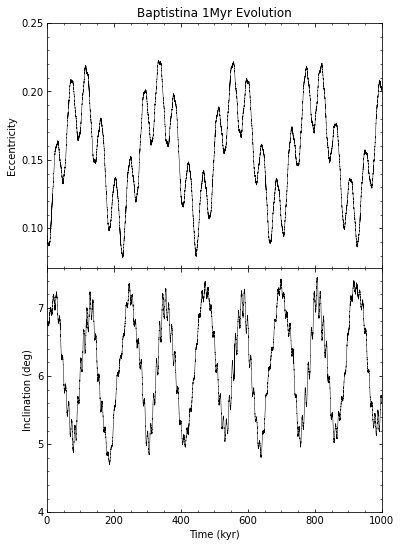

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (6,9))
ax1.plot(ts, eccentricities, lw = .5, c = 'k')
ax1.set_ylabel("Eccentricity")
ax1.set_yticks([0.1, 0.15, 0.2, 0.25])
ax1.minorticks_on()
ax1.tick_params(which='both', direction = 'in', top=True, right=True)
ax2.minorticks_on()
ax2.tick_params(which='both', direction = 'in', top=True, right=True)
ax2.plot(ts, inclinations, lw = .5, c = 'k')
ax2.set_yticks([4, 5, 6, 7])
ax2.set_ylabel('Inclination (deg)')
ax2.set_xlabel('Time (kyr)')
plt.subplots_adjust(hspace=0)
ax1.set_title("Baptistina 1Myr Evolution")
plt.xlim(0, 1e3)

78.5 0.2057170893696328 4.873876562596722


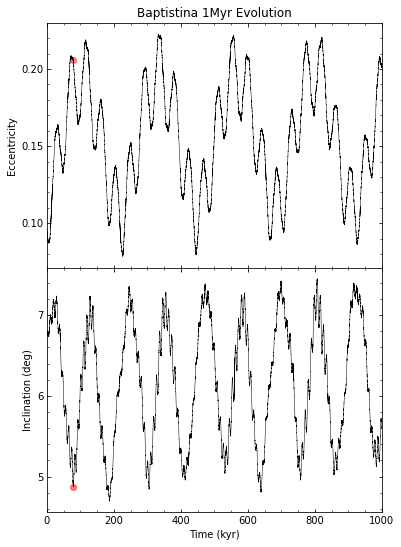

In [8]:
max_val = 0
max_i = 0
for i, (e, inc) in enumerate(zip(eccentricities, inclinations)):
    if e/inc > max_val: # and ts[i] < 200:
        max_val = e/inc
        max_i = i
print(ts[max_i], eccentricities[max_i], inclinations[max_i])

ax1.scatter(ts[max_i], eccentricities[max_i], c='red', alpha = .5)
ax2.scatter(ts[max_i], inclinations[max_i], c='red', alpha = .5)
fig

In [82]:
Bap_init_1= sa[max_i]
Bap_init_1.move_to_com()
Bap_init_1.integrate(Bap_init_1.t+0.4*sec2year)
ps = Bap_init_1.particles
Bap = ps["Bap"]
bap_orb = Bap.calculate_orbit(ps[0])
Bap_init_1.t = 0
Bap_init_1.save('../data/sim_inits/Bap_Init_1.bin')

In [83]:
print(bap_orb.a*m2au, bap_orb.e, bap_orb.inc*rad2Deg, bap_orb.omega*rad2Deg, bap_orb.f*rad2Deg)

2.263068169159457 0.20573667063349138 3.473912208657329 272.4886965379246 106.84569446933389


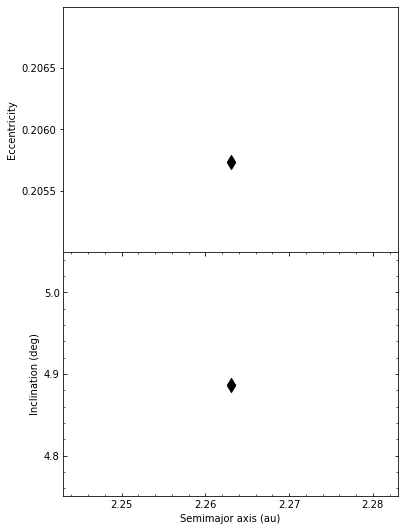

In [84]:
fig3, (ax3, ax4) = plt.subplots(2, 1, figsize = (6, 9), sharex=True)
plt.subplots_adjust(hspace=0)
ax1.minorticks_on()
ax1.tick_params(which='both', direction = 'in', top=True, right=True)
ax3.set_ylabel("Eccentricity")
ax3.set_ylim(0.205, 0.207)
ax3.set_yticks([0.2055, 0.206, 0.2065])
ax4.minorticks_on()
ax4.tick_params(which='both', direction = 'in', top=True, right=True)
ax4.set_ylabel("Inclination (deg)")
ax4.set_xlabel("Semimajor axis (au)")
ax4.set_ylim(4.75, 5.05)
ax4.set_yticks([4.8, 4.9, 5.0])
ax4.set_xlim(2.243, 2.283)
ax4.set_xticks([2.25, 2.26, 2.27, 2.28])
ax3.scatter(bap_orb.a*m2au, bap_orb.e, c = 'k', marker = 'd', s = 100)
ax4.scatter(bap_orb.a*m2au, invariable_inc(Bap_init_1, ps["Bap"]), c = 'k', marker = 'd', s = 100)

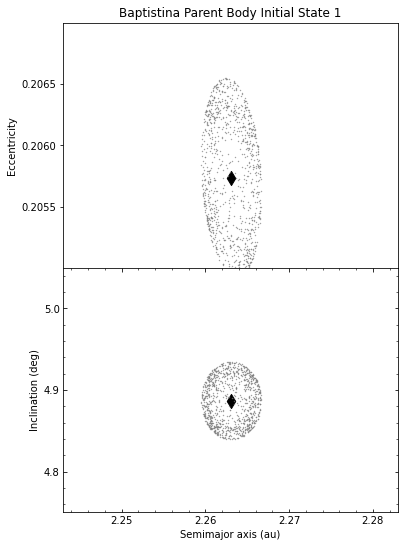

In [85]:
eject_vectors = [EjectionVector(16) for i in range(int(1e3))]
x, y, z = Bap.xyz
vx, vy, vz = Bap.vxyz
for v in eject_vectors:
    Bap_init_1.add(x=x, y=y, z=z,vx=vx+v[0], vy=vy+v[1], vz=vz+v[2])
orbs = Bap_init_1.calculate_orbits(primary = ps["Sun"])[8:]
p_as = [orb.a*m2au for orb in orbs]
p_es = [orb.e for orb in orbs]
p_incs = [invariable_inc(Bap_init_1, p) for p in ps[9:]]
ax3.scatter(p_as, p_es, c = 'grey', marker = '.', s = .5)
ax4.scatter(p_as, p_incs, c = 'grey', marker = '.', s = .5)
ax3.set_title("Baptistina Parent Body Initial State 1")
fig3